## Import packages

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

## Data preparation

In [175]:
real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/data/EURUSD/EURUSD_H1_200702210000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
# df = df.iloc[-(200+24*7*4):]
# df = df.iloc[-70_000:]
# df = df.iloc[-100_000:]
# take only first 7000 rows
# df = df.iloc[:7000]
# from 7000 to 14000
df = df.iloc[7_000:20_000]

# df = df.iloc[-(24*7*3):]
# df = df.iloc[-(24*5):]
# df = df.iloc[-120:]
# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# convert the date_time column to datetime
df['Time'] = pd.to_datetime(df['Date_Time'])
# Rename Date_Time to Time
# df.index = df['Time']
# df.set_index("Time")
# remove the Time column
df = df.drop(['Time'], axis=1)

prices = df["Close"].values
# df["SMA"] = talib.SMA(prices, timeperiod=200)
df["SMA"] = talib.SMA(prices, timeperiod=200)
df["MACD"], df["MACD_Signal"], df["MACD_Hist"] = talib.MACD(df["Close"])

df["Crossover"] = np.where(df["MACD"] > df["MACD_Signal"], 1, -1)
df["Crossover_Change"] = df["Crossover"].diff()
df = df.dropna()


In [162]:
y = df[['SMA']]
df

,Open,High,Low,Close,Date_Time,SMA,MACD,MACD_Signal,MACD_Hist,Crossover,Crossover_Change
7199,1.58890,1.58910,1.58800,1.58890,2008.04.23 22:00:00,1.587118,-0.001839,-0.001128,-0.000710,-1,0.0
7200,1.58900,1.58960,1.58800,1.58830,2008.04.23 23:00:00,1.587146,-0.001905,-0.001284,-0.000621,-1,0.0
7201,1.58860,1.58890,1.58700,1.58730,2008.04.24 00:00:00,1.587171,-0.002014,-0.001430,-0.000585,-1,0.0
7202,1.58740,1.58810,1.58710,1.58810,2008.04.24 01:00:00,1.587199,-0.002013,-0.001547,-0.000467,-1,0.0
7203,1.58800,1.58840,1.58740,1.58770,2008.04.24 02:00:00,1.587228,-0.002022,-0.001642,-0.000380,-1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
39995,1.32908,1.33024,1.32877,1.32967,2013.08.12 12:00:00,1.329468,-0.001572,-0.001258,-0.000315,-1,0.0
39996,1.32967,1.32994,1.32875,1.32875,2013.08.12 13:00:00,1.329480,-0.001681,-0.001342,-0.000339,-1,0.0
39997,1.32875,1.32906,1.32772,1.32891,2013.08.12 14:00:00,1.329497,-0.001735,-0.001421,-0.000314,-1,0.0
39998,1.32889,1.32921,1.32838,1.32847,2013.08.12 15:00:00,1.329511,-0.001792,-0.001495,-0.000297,-1,0.0


<Axes: >

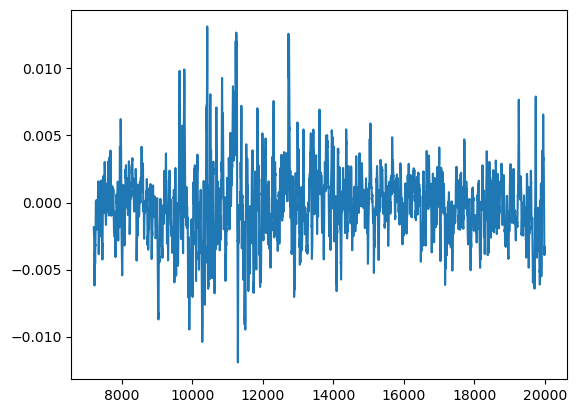

In [78]:
df['MACD'].plot()

In [ ]:
from sktime.utils.plotting import plot_series
plot_series(y)

## Forecasting with Linear Regression

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y, test_size=24*5) # Predict from 1st July 2019

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression, LassoCV
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=20, strategy="recursive")
forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')

print('MAPE: %.6f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
y_close = df[['Close']]
# last 120 rows
y_close = y_close.iloc[-120:]

In [187]:
import sys
import os
import pandas as pd
import numpy as np
import talib
from sklearn.linear_model import *
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.model_selection import SlidingWindowSplitter
import warnings

splitter = SlidingWindowSplitter(window_length = 67_20, 
                                #  fh = np.arange(1, 120 + 1), 
                                 fh = np.arange(1, 240 + 1), 
                                 step_length = 24 * 5)
y = df[['SMA']]


# Initialize an empty numpy array of dictionaries
orders = np.array([])
outcomes = []


offset = y.index[0]
for j, (train_idx, test_idx) in enumerate(splitter.split(y)):
    train_idx = train_idx + offset
    test_idx = test_idx + offset
    
    y_train = y.loc[train_idx]
    y_test = y.loc[test_idx]
    
    regressor = LinearRegression()
    forecaster = make_reduction(regressor, window_length = 570, strategy = "recursive")
    forecaster.fit(y_train)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    y_pred = forecaster.predict(fh)
    
    # get last 120 indices from train_idx
    sub_train_idx = train_idx[-24:]
    # sub_train_idx = train_idx[-240:]
    # combine last 120 indices from train_idx with test_idx
    sub_train_test_idx = np.concatenate([sub_train_idx, test_idx])
    y_test_close = df[['Close']].loc[sub_train_test_idx]
    
    # calculate the Fibonacci retracement levels
    # find the highest and lowest prices in the data
    high = df[['Close']].loc[sub_train_idx]['Close'].max()
    low = df[['Close']].loc[sub_train_idx]['Close'].min()
    fib_levels = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    fib_prices = [high - level * (high - low) for level in fib_levels]
    
    
    # y_test_sma = df[['SMA']].iloc[sub_train_test_idx]
    y_pred_prev = df[['SMA']].loc[sub_train_idx]
    y_pred_combined = pd.concat([y_pred_prev, y_pred])
    y_pred_combined_flatten = y_pred_combined.values.flatten()
    x = np.arange(1, len(y_pred_combined_flatten) + 1)
    
    slope, intercept = np.polyfit(x, y_pred_combined_flatten, 1)
    y_fit = np.polyval([slope, intercept], x)
    mse = np.mean((y_pred_combined_flatten - y_fit) ** 2)
    mse = mse * 10e8
    slope = slope * 10e5
    slope_threshold = 10
    # slope_threshold = 0
    
    # create an order dictionary with ask_price, take_profit_price, stop_loss_price and position
    if abs(slope) > slope_threshold:
        has_traded = False
        # check if the slope is positive or negative
        if slope > 0:
            # if the slope is positive, then the trend is positive
            # if there is a buy MACD crossover in the test_idx, then create the order dictionary
            # loop through test_idx
            appended_outcome = False
            for i in test_idx:
                # check if there is a buy MACD crossover
                if df.loc[i, "Crossover_Change"] > 0 and \
                    has_traded == False and \
                    df.loc[i, "Close"] > df.loc[i, "SMA"] and \
                    df.loc[i, "MACD"] < 0:
                    ask_price = df.loc[i, "Close"]
                    # tp_price = fib_prices[0]
                    # sl_price = fib_prices[2]
                    tp_price = ask_price + 0.0150
                    sl_price = ask_price - 0.0100
                    
                    order = {
                        "ask_price": ask_price,
                        "take_profit_price": tp_price, 
                        "stop_loss_price": sl_price, 
                        "position": "long",
                        "MACD" : df.loc[i, "MACD"],
                        "SMA" : df.loc[i, "SMA"],
                    }
                    orders = np.append(orders, order)
                    has_traded = True
                
                if has_traded == True:
                    close_price = df.loc[i, "Close"]
                    if close_price >= tp_price:
                        outcomes.append(1)
                        appended_outcome = True
                        break
                    elif close_price <= sl_price:
                        outcomes.append(0)
                        appended_outcome = True
                        break
            # if appended_outcome == False:
            #     if df.loc[test_idx[-1], "Close"] >= ask_price:
            #         outcomes.append(1)
            #     else:
            #         outcomes.append(0)
        else:
            # continue
            appended_outcome = False
            for i in test_idx:
                # check if there is a sell MACD crossover
                if df.loc[i, "Crossover_Change"] < 0 and \
                    has_traded == False and \
                    df.loc[i, "Close"] < df.loc[i, "SMA"] and \
                    df.loc[i, "MACD"] > 0:
                    # if there is a sell MACD crossover, then create the order dictionary
                    ask_price = df.loc[i, "Close"]
                    # tp_price = fib_prices[5]
                    # sl_price = fib_prices[0]
                    tp_price = ask_price - 0.0150
                    sl_price = ask_price + 0.0100
                    
                    order = {
                        "ask_price": ask_price,
                        "take_profit_price": tp_price, 
                        "stop_loss_price": sl_price, 
                        "position": "short",
                        "MACD" : df.loc[i, "MACD"],
                        "SMA" : df.loc[i, "SMA"],
                    }
                    # append the order dictionary to the orders array
                    orders = np.append(orders, order)
                    has_traded = True
                
                if has_traded == True:
                    close_price = df.loc[i, "Close"]
                    if close_price <= tp_price:
                        outcomes.append(1)
                        appended_outcome = True
                        break
                    elif close_price >= sl_price:
                        outcomes.append(0)
                        appended_outcome = True
                        break
            # if appended_outcome == False:
            #     if df.loc[test_idx[-1], "Close"] <= ask_price:
            #         outcomes.append(1)
            #     else:
            #         outcomes.append(0)   
    
    # fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    # ax1.scatter(x, y_pred_combined_flatten, color="blue", label="Predicted data")
    # ax1.plot(x, y_test_close.values.flatten(), color="black", label="Actual Close data")
    # ax1.plot(x, y_fit, color="red", linestyle="--", label="Fitted line")
    # ax1.set_title(f"Polyfit, Slope = {slope:.3f}, MSE = {mse:.3f}", fontsize=10)
    # ax1.set_ylabel("y")
    # ax1.legend()
    
    # for price in fib_prices:
    #     ax1.axhline(price, 
    #                 linestyle='--', 
    #                 color='grey', 
    #                 label=f'Fibonacci {fib_levels[fib_prices.index(price)] * 100}%')
    
    # # Plot macd as a black solid line using ax2.plot()
    # macd = df['MACD'].loc[sub_train_test_idx]
    # macd_signal = df['MACD_Signal'].loc[sub_train_test_idx]
    # macd_hist = df['MACD_Hist'].loc[sub_train_test_idx]
    
    # ax2.plot(x, macd, color="blue", label="MACD")
    # ax2.plot(x, macd_signal, color="orange", label="Signal")
    # ax2.bar(x, macd_hist, color=["red" if x < 0 else "green" for x in macd_hist], label="Histogram")
    # ax2.set_xlabel("x")
    # ax2.set_ylabel("MACD")
    # ax2.legend()
    
    # plt.show()



In [185]:
from sklearn.metrics import accuracy_score

# outcomes
test_y = [1] * len(outcomes)
accuracy = accuracy_score(test_y, outcomes)

print(f"Accuracy: {accuracy}")

Accuracy: 0.36666666666666664


In [ ]:
# Accuracy: 0.4146341463414634

In [186]:
print(f"Number of trades: {len(outcomes)}")
print(f"Number of wins: {sum(outcomes)}")
print(f"Number of losses: {len(outcomes) - sum(outcomes)}")
print(outcomes)

Number of trades: 30
Number of wins: 11
Number of losses: 19
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]


In [183]:
print(len(orders))
print(orders)

35
[{'ask_price': 1.38792, 'take_profit_price': 1.40292, 'stop_loss_price': 1.37792, 'position': 'long', 'MACD': -0.002814105389191468, 'SMA': 1.3807390999999978}
 {'ask_price': 1.40854, 'take_profit_price': 1.39354, 'stop_loss_price': 1.41854, 'position': 'short', 'MACD': 0.0037255925859518424, 'SMA': 1.41043645}
 {'ask_price': 1.40752, 'take_profit_price': 1.3925200000000002, 'stop_loss_price': 1.4175200000000001, 'position': 'short', 'MACD': 0.0019121131103274625, 'SMA': 1.4087909999999997}
 {'ask_price': 1.39475, 'take_profit_price': 1.37975, 'stop_loss_price': 1.40475, 'position': 'short', 'MACD': 0.002118200889454247, 'SMA': 1.394960800000001}
 {'ask_price': 1.39444, 'take_profit_price': 1.37944, 'stop_loss_price': 1.40444, 'position': 'short', 'MACD': 0.0004930633456154965, 'SMA': 1.4027329999999987}
 {'ask_price': 1.39792, 'take_profit_price': 1.41292, 'stop_loss_price': 1.38792, 'position': 'long', 'MACD': -0.00016667361789868274, 'SMA': 1.395605549999999}
 {'ask_price': 1.399

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### XGBoost with multiple inputs

### Tuning the hyperparameters of our forecaster

In [ ]:
from sktime.forecasting.model_selection import SingleWindowSplitter, ForecastingRandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=1)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")
gscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=SlidingWindowSplitter(window_length=len(y_train)-26, fh=26), param_distributions= {
                                        'deseasonalize__model': ['multiplicative', 'additive'],
                                        'detrend__forecaster__degree': [1, 2, 3],
                                        'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
                                        'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
                                        'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
                                        'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                                        'forecast__estimator__n_estimators': [100, 500, 1000],
                                    }, 
                                     n_iter=1_00, 
                                     random_state=1)

forecaster.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.cv_results_

## Adding components to our forecasting pipeline

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import SingleWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

regressor = XGBRegressor(objective='reg:squarederror', random_state=1)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=52, strategy="recursive")),
    ]
)

param_grid = {
    'deseasonalize__model': ['multiplicative', 'additive'],
    'detrend__forecaster__degree': [1, 2, 3],
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 500, 1000]
}

gscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=SlidingWindowSplitter(window_length=len(y_train)-26, fh=26), param_distributions=param_grid, 
                                     n_iter=1_00, 
                                     random_state=1)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
gscv.cv_results_

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

# declarative forecaster specification - just two lines!
regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, window_length=55, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)


In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet
# Prophet requires to have data with a pandas.DatetimeIndex
forecaster = Prophet(  
    seasonality_mode='multiplicative',
    # n_changepoints=int(len(y) / 12),
    )
# forecaster.fit(y_train)  

# y_pred = forecaster.predict(fh=[1,2,3])  